In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import warnings

# 경고 메시지 숨기기
warnings.filterwarnings(action='ignore')

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드 함수
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    
    data = np.array([signal for signal, meta in data])
    return data

path = './ecg_dataset/'
sampling_rate = 100

# load and convert annotation data
Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Train과 Test 데이터 분할 (8:2)
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, Y.diagnostic_superclass, test_size=0.2, random_state=42)

In [2]:
# 레이블 처리
y_train_labels = [set(labels) for labels in y_train_encoded]
y_test_labels = [set(labels) for labels in y_test_encoded]

# 데이터 전처리
X_train = [x for x, labels in zip(X_train, y_train_labels) if len(labels) > 0]
X_train = [torch.from_numpy(x) for x in X_train]  # Convert NumPy arrays to PyTorch tensors
X_train = torch.stack(X_train) if len(X_train) > 0 else None  # 리스트를 PyTorch Tensor로 변환
y_train_labels = [labels for labels in y_train_labels if len(labels) > 0]

X_test = [x for x, labels in zip(X_test, y_test_labels) if len(labels) > 0]
X_test = [torch.from_numpy(x) for x in X_test]  # Convert NumPy arrays to PyTorch tensors
X_test = torch.stack(X_test) if len(X_test) > 0 else None  # 리스트를 PyTorch Tensor로 변환
y_test_labels = [labels for labels in y_test_labels if len(labels) > 0]

# 데이터가 비어있는 경우에 대한 예외 처리
if X_train is not None:
    X_train = X_train.permute(0, 2, 1)

if X_test is not None:
    X_test = X_test.permute(0, 2, 1)

# 전체 레이블 목록 생성
all_labels = list(set(label for labels in y_train_labels for label in labels))

# 레이블을 이진 벡터로 인코딩
def encode_labels(labels, all_labels):
    encoded_labels = [1 if label in labels else 0 for label in all_labels]
    return torch.tensor(encoded_labels, dtype=torch.float32)

y_train_encoded = torch.stack([encode_labels(labels, all_labels) for labels in y_train_labels])
y_test_encoded = torch.stack([encode_labels(labels, all_labels) for labels in y_test_labels])

y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32).to(device)

Training Fold 1...


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:24<00:00, 18.60it/s]


Epoch 1, Average Training Loss: 0.3702
Epoch 1, Validation AUC: 0.9070


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.21it/s]


Epoch 2, Average Training Loss: 0.3228
Epoch 2, Validation AUC: 0.9148


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.98it/s]


Epoch 3, Average Training Loss: 0.3104
Epoch 3, Validation AUC: 0.9178


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.96it/s]


Epoch 4, Average Training Loss: 0.3009
Epoch 4, Validation AUC: 0.9256


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.07it/s]


Epoch 5, Average Training Loss: 0.2917
Epoch 5, Validation AUC: 0.9263


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.17it/s]


Epoch 6, Average Training Loss: 0.2866
Epoch 6, Validation AUC: 0.9278


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.26it/s]


Epoch 7, Average Training Loss: 0.2824
Epoch 7, Validation AUC: 0.9237


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.21it/s]


Epoch 8, Average Training Loss: 0.2762
Epoch 8, Validation AUC: 0.9298


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.20it/s]


Epoch 9, Average Training Loss: 0.2735
Epoch 9, Validation AUC: 0.9340


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.10it/s]


Epoch 10, Average Training Loss: 0.2686
Epoch 10, Validation AUC: 0.9332


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.14it/s]


Epoch 11, Average Training Loss: 0.2661
Epoch 11, Validation AUC: 0.9318


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.96it/s]


Epoch 12, Average Training Loss: 0.2622
Epoch 12, Validation AUC: 0.9354


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.85it/s]


Epoch 13, Average Training Loss: 0.2587
Epoch 13, Validation AUC: 0.9360


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.84it/s]


Epoch 14, Average Training Loss: 0.2561
Epoch 14, Validation AUC: 0.9343


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.86it/s]


Epoch 15, Average Training Loss: 0.2544
Epoch 15, Validation AUC: 0.9364


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.78it/s]


Epoch 16, Average Training Loss: 0.2485
Epoch 16, Validation AUC: 0.9383


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.85it/s]


Epoch 17, Average Training Loss: 0.2462
Epoch 17, Validation AUC: 0.9368


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.11it/s]


Epoch 18, Average Training Loss: 0.2458
Epoch 18, Validation AUC: 0.9368


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.11it/s]


Epoch 19, Average Training Loss: 0.2418
Epoch 19, Validation AUC: 0.9383


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.10it/s]


Epoch 20, Average Training Loss: 0.2392
Epoch 20, Validation AUC: 0.9371


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.01it/s]


Epoch 21, Average Training Loss: 0.2351
Epoch 21, Validation AUC: 0.9345
Early stopping at epoch 21
Best AUC: 0.9383 (Epoch 21)
Training Fold 2...


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.55it/s]


Epoch 1, Average Training Loss: 0.3752
Epoch 1, Validation AUC: 0.9056


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.98it/s]


Epoch 2, Average Training Loss: 0.3248
Epoch 2, Validation AUC: 0.9159


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.02it/s]


Epoch 3, Average Training Loss: 0.3141
Epoch 3, Validation AUC: 0.9158


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.99it/s]


Epoch 4, Average Training Loss: 0.3011
Epoch 4, Validation AUC: 0.9236


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.08it/s]


Epoch 5, Average Training Loss: 0.2942
Epoch 5, Validation AUC: 0.9250


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.28it/s]


Epoch 6, Average Training Loss: 0.2883
Epoch 6, Validation AUC: 0.9280


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.05it/s]


Epoch 7, Average Training Loss: 0.2842
Epoch 7, Validation AUC: 0.9310


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.98it/s]


Epoch 8, Average Training Loss: 0.2780
Epoch 8, Validation AUC: 0.9311


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.94it/s]


Epoch 9, Average Training Loss: 0.2739
Epoch 9, Validation AUC: 0.9301


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.99it/s]


Epoch 10, Average Training Loss: 0.2690
Epoch 10, Validation AUC: 0.9347


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.06it/s]


Epoch 11, Average Training Loss: 0.2659
Epoch 11, Validation AUC: 0.9319


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.90it/s]


Epoch 12, Average Training Loss: 0.2650
Epoch 12, Validation AUC: 0.9363


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.76it/s]


Epoch 13, Average Training Loss: 0.2601
Epoch 13, Validation AUC: 0.9351


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.97it/s]


Epoch 14, Average Training Loss: 0.2556
Epoch 14, Validation AUC: 0.9393


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.95it/s]


Epoch 15, Average Training Loss: 0.2540
Epoch 15, Validation AUC: 0.9367


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.77it/s]


Epoch 16, Average Training Loss: 0.2512
Epoch 16, Validation AUC: 0.9361


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.71it/s]


Epoch 17, Average Training Loss: 0.2472
Epoch 17, Validation AUC: 0.9369


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.93it/s]


Epoch 18, Average Training Loss: 0.2459
Epoch 18, Validation AUC: 0.9365


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.09it/s]


Epoch 19, Average Training Loss: 0.2441
Epoch 19, Validation AUC: 0.9360
Early stopping at epoch 19
Best AUC: 0.9393 (Epoch 19)
Training Fold 3...


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.76it/s]


Epoch 1, Average Training Loss: 0.3671
Epoch 1, Validation AUC: 0.8933


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.91it/s]


Epoch 2, Average Training Loss: 0.3214
Epoch 2, Validation AUC: 0.9084


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.03it/s]


Epoch 3, Average Training Loss: 0.3111
Epoch 3, Validation AUC: 0.9151


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.02it/s]


Epoch 4, Average Training Loss: 0.2993
Epoch 4, Validation AUC: 0.9181


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.99it/s]


Epoch 5, Average Training Loss: 0.2927
Epoch 5, Validation AUC: 0.9202


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.92it/s]


Epoch 6, Average Training Loss: 0.2854
Epoch 6, Validation AUC: 0.9179


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.06it/s]


Epoch 7, Average Training Loss: 0.2822
Epoch 7, Validation AUC: 0.9239


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.09it/s]


Epoch 8, Average Training Loss: 0.2738
Epoch 8, Validation AUC: 0.9290


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.12it/s]


Epoch 9, Average Training Loss: 0.2723
Epoch 9, Validation AUC: 0.9266


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.02it/s]


Epoch 10, Average Training Loss: 0.2689
Epoch 10, Validation AUC: 0.9306


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.78it/s]


Epoch 11, Average Training Loss: 0.2640
Epoch 11, Validation AUC: 0.9303


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.84it/s]


Epoch 12, Average Training Loss: 0.2604
Epoch 12, Validation AUC: 0.9292


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.94it/s]


Epoch 13, Average Training Loss: 0.2578
Epoch 13, Validation AUC: 0.9331


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.90it/s]


Epoch 14, Average Training Loss: 0.2546
Epoch 14, Validation AUC: 0.9277


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.91it/s]


Epoch 15, Average Training Loss: 0.2516
Epoch 15, Validation AUC: 0.9318


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.80it/s]


Epoch 16, Average Training Loss: 0.2479
Epoch 16, Validation AUC: 0.9358


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.93it/s]


Epoch 17, Average Training Loss: 0.2463
Epoch 17, Validation AUC: 0.9315


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.14it/s]


Epoch 18, Average Training Loss: 0.2441
Epoch 18, Validation AUC: 0.9329


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.03it/s]


Epoch 19, Average Training Loss: 0.2410
Epoch 19, Validation AUC: 0.9366


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.85it/s]


Epoch 20, Average Training Loss: 0.2383
Epoch 20, Validation AUC: 0.9369


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.99it/s]


Epoch 21, Average Training Loss: 0.2360
Epoch 21, Validation AUC: 0.9359


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.93it/s]


Epoch 22, Average Training Loss: 0.2324
Epoch 22, Validation AUC: 0.9317


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.07it/s]


Epoch 23, Average Training Loss: 0.2291
Epoch 23, Validation AUC: 0.9338


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.01it/s]


Epoch 24, Average Training Loss: 0.2255
Epoch 24, Validation AUC: 0.9374


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.97it/s]


Epoch 25, Average Training Loss: 0.2258
Epoch 25, Validation AUC: 0.9322


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.06it/s]


Epoch 26, Average Training Loss: 0.2221
Epoch 26, Validation AUC: 0.9369


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.99it/s]


Epoch 27, Average Training Loss: 0.2196
Epoch 27, Validation AUC: 0.9373


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.12it/s]


Epoch 28, Average Training Loss: 0.2172
Epoch 28, Validation AUC: 0.9345


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.04it/s]


Epoch 29, Average Training Loss: 0.2142
Epoch 29, Validation AUC: 0.9347
Early stopping at epoch 29
Best AUC: 0.9374 (Epoch 29)
Training Fold 4...


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.88it/s]


Epoch 1, Average Training Loss: 0.3702
Epoch 1, Validation AUC: 0.9000


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.02it/s]


Epoch 2, Average Training Loss: 0.3255
Epoch 2, Validation AUC: 0.9162


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.11it/s]


Epoch 3, Average Training Loss: 0.3076
Epoch 3, Validation AUC: 0.9228


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.06it/s]


Epoch 4, Average Training Loss: 0.2988
Epoch 4, Validation AUC: 0.9238


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.13it/s]


Epoch 5, Average Training Loss: 0.2916
Epoch 5, Validation AUC: 0.9252


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.11it/s]


Epoch 6, Average Training Loss: 0.2852
Epoch 6, Validation AUC: 0.9271


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.99it/s]


Epoch 7, Average Training Loss: 0.2824
Epoch 7, Validation AUC: 0.9305


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.85it/s]


Epoch 8, Average Training Loss: 0.2769
Epoch 8, Validation AUC: 0.9313


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.90it/s]


Epoch 9, Average Training Loss: 0.2733
Epoch 9, Validation AUC: 0.9306


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.88it/s]


Epoch 10, Average Training Loss: 0.2704
Epoch 10, Validation AUC: 0.9312


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.82it/s]


Epoch 11, Average Training Loss: 0.2652
Epoch 11, Validation AUC: 0.9291


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.85it/s]


Epoch 12, Average Training Loss: 0.2622
Epoch 12, Validation AUC: 0.9330


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.84it/s]


Epoch 13, Average Training Loss: 0.2588
Epoch 13, Validation AUC: 0.9347


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.05it/s]


Epoch 14, Average Training Loss: 0.2563
Epoch 14, Validation AUC: 0.9350


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.04it/s]


Epoch 15, Average Training Loss: 0.2534
Epoch 15, Validation AUC: 0.9363


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 42.98it/s]


Epoch 16, Average Training Loss: 0.2513
Epoch 16, Validation AUC: 0.9340


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.04it/s]


Epoch 17, Average Training Loss: 0.2467
Epoch 17, Validation AUC: 0.9375


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.15it/s]


Epoch 18, Average Training Loss: 0.2455
Epoch 18, Validation AUC: 0.9329


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.17it/s]


Epoch 19, Average Training Loss: 0.2412
Epoch 19, Validation AUC: 0.9370


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.15it/s]


Epoch 20, Average Training Loss: 0.2402
Epoch 20, Validation AUC: 0.9348


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.37it/s]


Epoch 21, Average Training Loss: 0.2357
Epoch 21, Validation AUC: 0.9347


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:10<00:00, 43.31it/s]


Epoch 22, Average Training Loss: 0.2370
Epoch 22, Validation AUC: 0.9365
Early stopping at epoch 22
Best AUC: 0.9375 (Epoch 22)
Training Fold 5...


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.94it/s]


Epoch 1, Average Training Loss: 0.3665
Epoch 1, Validation AUC: 0.9033


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.11it/s]


Epoch 2, Average Training Loss: 0.3233
Epoch 2, Validation AUC: 0.9082


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.10it/s]


Epoch 3, Average Training Loss: 0.3088
Epoch 3, Validation AUC: 0.9140


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.15it/s]


Epoch 4, Average Training Loss: 0.2976
Epoch 4, Validation AUC: 0.9172


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.11it/s]


Epoch 5, Average Training Loss: 0.2910
Epoch 5, Validation AUC: 0.9191


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.18it/s]


Epoch 6, Average Training Loss: 0.2869
Epoch 6, Validation AUC: 0.9270


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.99it/s]


Epoch 7, Average Training Loss: 0.2798
Epoch 7, Validation AUC: 0.9293


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.09it/s]


Epoch 8, Average Training Loss: 0.2766
Epoch 8, Validation AUC: 0.9293


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.01it/s]


Epoch 9, Average Training Loss: 0.2718
Epoch 9, Validation AUC: 0.9271


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.98it/s]


Epoch 10, Average Training Loss: 0.2678
Epoch 10, Validation AUC: 0.9315


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.83it/s]


Epoch 11, Average Training Loss: 0.2649
Epoch 11, Validation AUC: 0.9325


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 42.96it/s]


Epoch 12, Average Training Loss: 0.2622
Epoch 12, Validation AUC: 0.9313


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.09it/s]


Epoch 13, Average Training Loss: 0.2576
Epoch 13, Validation AUC: 0.9339


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.20it/s]


Epoch 14, Average Training Loss: 0.2552
Epoch 14, Validation AUC: 0.9351


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.04it/s]


Epoch 15, Average Training Loss: 0.2507
Epoch 15, Validation AUC: 0.9351


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.10it/s]


Epoch 16, Average Training Loss: 0.2493
Epoch 16, Validation AUC: 0.9332


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.07it/s]


Epoch 17, Average Training Loss: 0.2430
Epoch 17, Validation AUC: 0.9347


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.15it/s]


Epoch 18, Average Training Loss: 0.2418
Epoch 18, Validation AUC: 0.9346


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.15it/s]


Epoch 19, Average Training Loss: 0.2398
Epoch 19, Validation AUC: 0.9357


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.15it/s]


Epoch 20, Average Training Loss: 0.2358
Epoch 20, Validation AUC: 0.9357


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.19it/s]


Epoch 21, Average Training Loss: 0.2339
Epoch 21, Validation AUC: 0.9363


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.30it/s]


Epoch 22, Average Training Loss: 0.2305
Epoch 22, Validation AUC: 0.9359


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.06it/s]


Epoch 23, Average Training Loss: 0.2279
Epoch 23, Validation AUC: 0.9352


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.01it/s]


Epoch 24, Average Training Loss: 0.2268
Epoch 24, Validation AUC: 0.9360


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.12it/s]


Epoch 25, Average Training Loss: 0.2226
Epoch 25, Validation AUC: 0.9341


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:10<00:00, 43.09it/s]


Epoch 26, Average Training Loss: 0.2183
Epoch 26, Validation AUC: 0.9336
Early stopping at epoch 26
Best AUC: 0.9363 (Epoch 26)


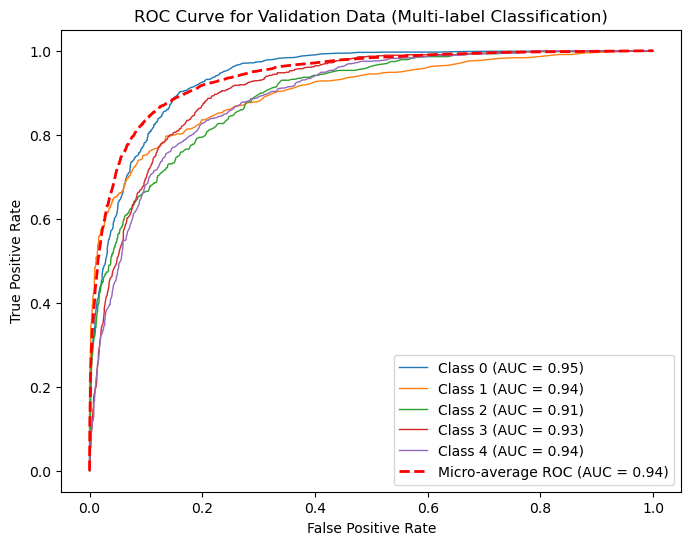

In [3]:
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import matplotlib.pyplot as plt

# 1차원 CNN Teacher 모델 정의
class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN1D, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=100, kernel_size=10)
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=250, kernel_size=10)
        self.conv3 = nn.Conv1d(in_channels=250, out_channels=500, kernel_size=10)
        self.conv4 = nn.Conv1d(in_channels=500, out_channels=1000, kernel_size=10)
        self.relu = nn.ReLU()
        
        self.bn1 = nn.BatchNorm1d(100)
        self.bn2 = nn.BatchNorm1d(250)
        self.bn3 = nn.BatchNorm1d(500)
        self.bn4 = nn.BatchNorm1d(1000)

        self.pool = nn.MaxPool1d(kernel_size=2)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # Global Average Pooling 레이어
        self.dropout1 = nn.Dropout(0.5, inplace=False)
        self.fc = nn.Linear(1000, num_classes)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, y=None):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Hyperparameters
num_classes = len(all_labels)
batch_size = 64
epochs = 50
learning_rate = 0.001
k_folds = 5

# K-Fold cross-validation 초기화
skf = MultilabelStratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# 폴드 별 각 label의 ROC data를 위한 list
all_fpr = []
all_tpr = []

# Early stopping parameters
patience = 5

# Teacher 모델 학습
# 폴드 별 학습 및 평가
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_encoded)):
    print(f"Training Fold {fold + 1}...")
    
    # model, optimizer, loss function 초기화
    model = CNN1D(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()  # Since we are using sigmoid activation in the model

    # 현재 폴드에 대한 데이터 로더 재정의
    train_loader = DataLoader(TensorDataset(X_train[train_idx].to(device).float(), y_train_tensor[train_idx].to(device).float()), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_train[val_idx].to(device).float(), y_train_tensor[val_idx].to(device).float()), batch_size=batch_size, shuffle=False)

    best_auc = 0.0
    no_improvement_epochs = 0
    
    # tqdm을 통해 학습 과정 표시
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_x.size(0)
        average_train_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}, Average Training Loss: {average_train_loss:.4f}")

        # Validation set evaluation
        model.eval()
        y_scores = []
        y_true = []
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                for batch_x, batch_y in val_loader:
                    output = model(batch_x)
                    output = nn.functional.sigmoid(output)
                    y_scores.append(output.cpu().numpy())
                    y_true.append(batch_y.cpu().numpy())

        y_scores = np.vstack(y_scores)
        y_true = np.vstack(y_true)
        
        # 각 label 별로 ROC curve 계산
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            all_fpr.append(fpr[i])
            all_tpr.append(tpr[i])

        # validation set에 대한 AUC score 계산
        auc_score = roc_auc_score(y_true, y_scores)

        print(f"Epoch {epoch + 1}, Validation AUC: {auc_score:.4f}")

        # AUC score 확인 후 갱신
        if auc_score > best_auc:
            best_auc = auc_score
            no_improvement_epochs = 0
        else:
            # Early stopping 확인
            no_improvement_epochs += 1
            if no_improvement_epochs >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    print(f"Best AUC: {best_auc:.4f} (Epoch {epoch + 1})")

# 각 label 별로 ROC curve를 plot
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(all_fpr[i], all_tpr[i], lw=1, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Micro-average ROC curve 계산 및 plot
micro_fpr, micro_tpr, _ = roc_curve(y_true.ravel(), y_scores.ravel())
micro_auc = auc(micro_fpr, micro_tpr)
plt.plot(micro_fpr, micro_tpr, color='red', linestyle='--', lw=2, label=f'Micro-average ROC (AUC = {micro_auc:.2f})')

# Labels 과 legend 추가
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Data (Multi-label Classification)')
plt.legend(loc='lower right')
plt.show()

In [4]:
# 지식 증류 학습을 위한 Knowledge Distillation Loss 함수 정의
def knowledge_distillation_loss(student_output, labels, teacher_output, T=1.0, alpha=0.7):

    #  student_output: Student 모델의 출력
    #  teacher_scores: Teacher 모델의 출력
    #  labels: 실제 레이블
    #  T: 온도 파라미터 (temperature)
    #  alpha: loss 가중치 파라미터

    # Cross-Entropy Loss (Soft Target)
    soft_loss = nn.KLDivLoss()(nn.functional.log_softmax(student_output / T, dim=1),
                                nn.functional.softmax(teacher_output / T, dim=1)) * (T * T)
    
    # Cross-Entropy Loss (Hard Target)
    hard_loss = nn.CrossEntropyLoss()(student_output, labels)
    
    # 최종 Loss = Hard Loss + alpha * Soft Loss
    loss = (1.0 - alpha) * hard_loss + alpha * soft_loss
    
    return loss

Training Fold 1...


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.22it/s]


Epoch 1, Average Training Loss: 0.8994
Epoch 1, Validation AUC: 0.9036


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.29it/s]


Epoch 2, Average Training Loss: 0.8372
Epoch 2, Validation AUC: 0.9156


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 73.74it/s]


Epoch 3, Average Training Loss: 0.8178
Epoch 3, Validation AUC: 0.9186


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 73.94it/s]


Epoch 4, Average Training Loss: 0.8053
Epoch 4, Validation AUC: 0.9213


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.09it/s]


Epoch 5, Average Training Loss: 0.7987
Epoch 5, Validation AUC: 0.9255


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 73.45it/s]


Epoch 6, Average Training Loss: 0.7899
Epoch 6, Validation AUC: 0.9254


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 68.60it/s]


Epoch 7, Average Training Loss: 0.7856
Epoch 7, Validation AUC: 0.9248


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.49it/s]


Epoch 8, Average Training Loss: 0.7794
Epoch 8, Validation AUC: 0.9275


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.72it/s]


Epoch 9, Average Training Loss: 0.7736
Epoch 9, Validation AUC: 0.9312


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.69it/s]


Epoch 10, Average Training Loss: 0.7698
Epoch 10, Validation AUC: 0.9313


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.14it/s]


Epoch 11, Average Training Loss: 0.7671
Epoch 11, Validation AUC: 0.9332


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.97it/s]


Epoch 12, Average Training Loss: 0.7656
Epoch 12, Validation AUC: 0.9306


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.11it/s]


Epoch 13, Average Training Loss: 0.7599
Epoch 13, Validation AUC: 0.9334


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.17it/s]


Epoch 14, Average Training Loss: 0.7550
Epoch 14, Validation AUC: 0.9318


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.80it/s]


Epoch 15, Average Training Loss: 0.7538
Epoch 15, Validation AUC: 0.9347


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.83it/s]


Epoch 16, Average Training Loss: 0.7523
Epoch 16, Validation AUC: 0.9336


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.24it/s]


Epoch 17, Average Training Loss: 0.7487
Epoch 17, Validation AUC: 0.9351


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.53it/s]


Epoch 18, Average Training Loss: 0.7445
Epoch 18, Validation AUC: 0.9360


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.08it/s]


Epoch 19, Average Training Loss: 0.7429
Epoch 19, Validation AUC: 0.9347


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.26it/s]


Epoch 20, Average Training Loss: 0.7396
Epoch 20, Validation AUC: 0.9353


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.88it/s]


Epoch 21, Average Training Loss: 0.7374
Epoch 21, Validation AUC: 0.9342


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.94it/s]


Epoch 22, Average Training Loss: 0.7343
Epoch 22, Validation AUC: 0.9368


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.54it/s]


Epoch 23, Average Training Loss: 0.7308
Epoch 23, Validation AUC: 0.9350


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.46it/s]


Epoch 24, Average Training Loss: 0.7305
Epoch 24, Validation AUC: 0.9370


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.77it/s]


Epoch 25, Average Training Loss: 0.7280
Epoch 25, Validation AUC: 0.9343


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.18it/s]


Epoch 26, Average Training Loss: 0.7251
Epoch 26, Validation AUC: 0.9375


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.30it/s]


Epoch 27, Average Training Loss: 0.7257
Epoch 27, Validation AUC: 0.9385


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.60it/s]


Epoch 28, Average Training Loss: 0.7199
Epoch 28, Validation AUC: 0.9354


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.05it/s]


Epoch 29, Average Training Loss: 0.7195
Epoch 29, Validation AUC: 0.9366


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.41it/s]


Epoch 30, Average Training Loss: 0.7166
Epoch 30, Validation AUC: 0.9380


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.28it/s]


Epoch 31, Average Training Loss: 0.7177
Epoch 31, Validation AUC: 0.9366


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.31it/s]


Epoch 32, Average Training Loss: 0.7117
Epoch 32, Validation AUC: 0.9378
Early stopping at epoch 32
Best AUC: 0.9385 (Epoch 32)
Training Fold 2...


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 73.07it/s]


Epoch 1, Average Training Loss: 0.8969
Epoch 1, Validation AUC: 0.8986


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.01it/s]


Epoch 2, Average Training Loss: 0.8424
Epoch 2, Validation AUC: 0.9125


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.14it/s]


Epoch 3, Average Training Loss: 0.8210
Epoch 3, Validation AUC: 0.9178


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.37it/s]


Epoch 4, Average Training Loss: 0.8108
Epoch 4, Validation AUC: 0.9143


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.04it/s]


Epoch 5, Average Training Loss: 0.8005
Epoch 5, Validation AUC: 0.9246


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.50it/s]


Epoch 6, Average Training Loss: 0.7910
Epoch 6, Validation AUC: 0.9271


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.58it/s]


Epoch 7, Average Training Loss: 0.7861
Epoch 7, Validation AUC: 0.9294


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.62it/s]


Epoch 8, Average Training Loss: 0.7815
Epoch 8, Validation AUC: 0.9302


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.00it/s]


Epoch 9, Average Training Loss: 0.7773
Epoch 9, Validation AUC: 0.9326


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.65it/s]


Epoch 10, Average Training Loss: 0.7748
Epoch 10, Validation AUC: 0.9300


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 73.94it/s]


Epoch 11, Average Training Loss: 0.7697
Epoch 11, Validation AUC: 0.9322


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.17it/s]


Epoch 12, Average Training Loss: 0.7663
Epoch 12, Validation AUC: 0.9336


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 73.77it/s]


Epoch 13, Average Training Loss: 0.7620
Epoch 13, Validation AUC: 0.9335


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.66it/s]


Epoch 14, Average Training Loss: 0.7572
Epoch 14, Validation AUC: 0.9359


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.49it/s]


Epoch 15, Average Training Loss: 0.7569
Epoch 15, Validation AUC: 0.9363


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.18it/s]


Epoch 16, Average Training Loss: 0.7515
Epoch 16, Validation AUC: 0.9363


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.70it/s]


Epoch 17, Average Training Loss: 0.7493
Epoch 17, Validation AUC: 0.9375


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.41it/s]


Epoch 18, Average Training Loss: 0.7482
Epoch 18, Validation AUC: 0.9372


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.96it/s]


Epoch 19, Average Training Loss: 0.7435
Epoch 19, Validation AUC: 0.9363


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.23it/s]


Epoch 20, Average Training Loss: 0.7411
Epoch 20, Validation AUC: 0.9368


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.33it/s]


Epoch 21, Average Training Loss: 0.7389
Epoch 21, Validation AUC: 0.9374


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.70it/s]


Epoch 22, Average Training Loss: 0.7378
Epoch 22, Validation AUC: 0.9365
Early stopping at epoch 22
Best AUC: 0.9375 (Epoch 22)
Training Fold 3...


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.23it/s]


Epoch 1, Average Training Loss: 0.8911
Epoch 1, Validation AUC: 0.9008


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.16it/s]


Epoch 2, Average Training Loss: 0.8329
Epoch 2, Validation AUC: 0.9071


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.23it/s]


Epoch 3, Average Training Loss: 0.8152
Epoch 3, Validation AUC: 0.9128


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.12it/s]


Epoch 4, Average Training Loss: 0.8059
Epoch 4, Validation AUC: 0.9180


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.60it/s]


Epoch 5, Average Training Loss: 0.7960
Epoch 5, Validation AUC: 0.9215


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.61it/s]


Epoch 6, Average Training Loss: 0.7905
Epoch 6, Validation AUC: 0.9212


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.58it/s]


Epoch 7, Average Training Loss: 0.7835
Epoch 7, Validation AUC: 0.9251


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.38it/s]


Epoch 8, Average Training Loss: 0.7792
Epoch 8, Validation AUC: 0.9263


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.44it/s]


Epoch 9, Average Training Loss: 0.7751
Epoch 9, Validation AUC: 0.9265


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.72it/s]


Epoch 10, Average Training Loss: 0.7705
Epoch 10, Validation AUC: 0.9276


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.45it/s]


Epoch 11, Average Training Loss: 0.7648
Epoch 11, Validation AUC: 0.9272


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.37it/s]


Epoch 12, Average Training Loss: 0.7615
Epoch 12, Validation AUC: 0.9279


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.13it/s]


Epoch 13, Average Training Loss: 0.7617
Epoch 13, Validation AUC: 0.9301


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.60it/s]


Epoch 14, Average Training Loss: 0.7563
Epoch 14, Validation AUC: 0.9302


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.81it/s]


Epoch 15, Average Training Loss: 0.7538
Epoch 15, Validation AUC: 0.9264


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.18it/s]


Epoch 16, Average Training Loss: 0.7500
Epoch 16, Validation AUC: 0.9336


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.81it/s]


Epoch 17, Average Training Loss: 0.7485
Epoch 17, Validation AUC: 0.9317


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.19it/s]


Epoch 18, Average Training Loss: 0.7463
Epoch 18, Validation AUC: 0.9308


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.23it/s]


Epoch 19, Average Training Loss: 0.7437
Epoch 19, Validation AUC: 0.9325


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.80it/s]


Epoch 20, Average Training Loss: 0.7381
Epoch 20, Validation AUC: 0.9342


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.87it/s]


Epoch 21, Average Training Loss: 0.7385
Epoch 21, Validation AUC: 0.9345


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.16it/s]


Epoch 22, Average Training Loss: 0.7353
Epoch 22, Validation AUC: 0.9328


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.62it/s]


Epoch 23, Average Training Loss: 0.7342
Epoch 23, Validation AUC: 0.9328


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.80it/s]


Epoch 24, Average Training Loss: 0.7311
Epoch 24, Validation AUC: 0.9358


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.29it/s]


Epoch 25, Average Training Loss: 0.7274
Epoch 25, Validation AUC: 0.9368


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.59it/s]


Epoch 26, Average Training Loss: 0.7260
Epoch 26, Validation AUC: 0.9383


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.22it/s]


Epoch 27, Average Training Loss: 0.7243
Epoch 27, Validation AUC: 0.9365


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.13it/s]


Epoch 28, Average Training Loss: 0.7229
Epoch 28, Validation AUC: 0.9349


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.69it/s]


Epoch 29, Average Training Loss: 0.7216
Epoch 29, Validation AUC: 0.9356


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.09it/s]


Epoch 30, Average Training Loss: 0.7186
Epoch 30, Validation AUC: 0.9376


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.24it/s]


Epoch 31, Average Training Loss: 0.7158
Epoch 31, Validation AUC: 0.9372
Early stopping at epoch 31
Best AUC: 0.9383 (Epoch 31)
Training Fold 4...


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.36it/s]


Epoch 1, Average Training Loss: 0.8920
Epoch 1, Validation AUC: 0.9018


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.95it/s]


Epoch 2, Average Training Loss: 0.8335
Epoch 2, Validation AUC: 0.9144


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.64it/s]


Epoch 3, Average Training Loss: 0.8192
Epoch 3, Validation AUC: 0.9137


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.88it/s]


Epoch 4, Average Training Loss: 0.8074
Epoch 4, Validation AUC: 0.9206


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.33it/s]


Epoch 5, Average Training Loss: 0.8015
Epoch 5, Validation AUC: 0.9202


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.36it/s]


Epoch 6, Average Training Loss: 0.7906
Epoch 6, Validation AUC: 0.9274


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.03it/s]


Epoch 7, Average Training Loss: 0.7862
Epoch 7, Validation AUC: 0.9278


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.32it/s]


Epoch 8, Average Training Loss: 0.7793
Epoch 8, Validation AUC: 0.9302


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.58it/s]


Epoch 9, Average Training Loss: 0.7761
Epoch 9, Validation AUC: 0.9291


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.42it/s]


Epoch 10, Average Training Loss: 0.7713
Epoch 10, Validation AUC: 0.9336


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.66it/s]


Epoch 11, Average Training Loss: 0.7641
Epoch 11, Validation AUC: 0.9332


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.69it/s]


Epoch 12, Average Training Loss: 0.7631
Epoch 12, Validation AUC: 0.9306


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.71it/s]


Epoch 13, Average Training Loss: 0.7602
Epoch 13, Validation AUC: 0.9336


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.66it/s]


Epoch 14, Average Training Loss: 0.7548
Epoch 14, Validation AUC: 0.9333


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.25it/s]


Epoch 15, Average Training Loss: 0.7520
Epoch 15, Validation AUC: 0.9346


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.74it/s]


Epoch 16, Average Training Loss: 0.7521
Epoch 16, Validation AUC: 0.9354


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.51it/s]


Epoch 17, Average Training Loss: 0.7478
Epoch 17, Validation AUC: 0.9344


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.85it/s]


Epoch 18, Average Training Loss: 0.7456
Epoch 18, Validation AUC: 0.9366


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.59it/s]


Epoch 19, Average Training Loss: 0.7430
Epoch 19, Validation AUC: 0.9341


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.51it/s]


Epoch 20, Average Training Loss: 0.7391
Epoch 20, Validation AUC: 0.9385


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.01it/s]


Epoch 21, Average Training Loss: 0.7369
Epoch 21, Validation AUC: 0.9379


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.39it/s]


Epoch 22, Average Training Loss: 0.7319
Epoch 22, Validation AUC: 0.9371


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.53it/s]


Epoch 23, Average Training Loss: 0.7293
Epoch 23, Validation AUC: 0.9349


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.84it/s]


Epoch 24, Average Training Loss: 0.7292
Epoch 24, Validation AUC: 0.9385


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.33it/s]


Epoch 25, Average Training Loss: 0.7260
Epoch 25, Validation AUC: 0.9386


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.63it/s]


Epoch 26, Average Training Loss: 0.7253
Epoch 26, Validation AUC: 0.9380


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.95it/s]


Epoch 27, Average Training Loss: 0.7232
Epoch 27, Validation AUC: 0.9384


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 75.10it/s]


Epoch 28, Average Training Loss: 0.7211
Epoch 28, Validation AUC: 0.9374


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.29it/s]


Epoch 29, Average Training Loss: 0.7190
Epoch 29, Validation AUC: 0.9375


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████| 458/458 [00:06<00:00, 74.49it/s]


Epoch 30, Average Training Loss: 0.7173
Epoch 30, Validation AUC: 0.9365
Early stopping at epoch 30
Best AUC: 0.9386 (Epoch 30)
Training Fold 5...


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 73.57it/s]


Epoch 1, Average Training Loss: 0.8976
Epoch 1, Validation AUC: 0.8901


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 73.94it/s]


Epoch 2, Average Training Loss: 0.8373
Epoch 2, Validation AUC: 0.9114


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 73.92it/s]


Epoch 3, Average Training Loss: 0.8169
Epoch 3, Validation AUC: 0.9129


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.25it/s]


Epoch 4, Average Training Loss: 0.8025
Epoch 4, Validation AUC: 0.9207


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.29it/s]


Epoch 5, Average Training Loss: 0.7961
Epoch 5, Validation AUC: 0.9214


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.08it/s]


Epoch 6, Average Training Loss: 0.7896
Epoch 6, Validation AUC: 0.9211


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 73.99it/s]


Epoch 7, Average Training Loss: 0.7834
Epoch 7, Validation AUC: 0.9249


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.42it/s]


Epoch 8, Average Training Loss: 0.7831
Epoch 8, Validation AUC: 0.9261


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.93it/s]


Epoch 9, Average Training Loss: 0.7742
Epoch 9, Validation AUC: 0.9288


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.25it/s]


Epoch 10, Average Training Loss: 0.7722
Epoch 10, Validation AUC: 0.9271


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.43it/s]


Epoch 11, Average Training Loss: 0.7693
Epoch 11, Validation AUC: 0.9290


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.09it/s]


Epoch 12, Average Training Loss: 0.7631
Epoch 12, Validation AUC: 0.9282


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.49it/s]


Epoch 13, Average Training Loss: 0.7620
Epoch 13, Validation AUC: 0.9318


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.21it/s]


Epoch 14, Average Training Loss: 0.7560
Epoch 14, Validation AUC: 0.9322


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.01it/s]


Epoch 15, Average Training Loss: 0.7557
Epoch 15, Validation AUC: 0.9298


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.12it/s]


Epoch 16, Average Training Loss: 0.7525
Epoch 16, Validation AUC: 0.9344


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.10it/s]


Epoch 17, Average Training Loss: 0.7482
Epoch 17, Validation AUC: 0.9324


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.29it/s]


Epoch 18, Average Training Loss: 0.7448
Epoch 18, Validation AUC: 0.9313


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.54it/s]


Epoch 19, Average Training Loss: 0.7434
Epoch 19, Validation AUC: 0.9332


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.81it/s]


Epoch 20, Average Training Loss: 0.7388
Epoch 20, Validation AUC: 0.9351


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.98it/s]


Epoch 21, Average Training Loss: 0.7387
Epoch 21, Validation AUC: 0.9335


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.26it/s]


Epoch 22, Average Training Loss: 0.7373
Epoch 22, Validation AUC: 0.9333


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.42it/s]


Epoch 23, Average Training Loss: 0.7348
Epoch 23, Validation AUC: 0.9358


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.79it/s]


Epoch 24, Average Training Loss: 0.7313
Epoch 24, Validation AUC: 0.9353


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.28it/s]


Epoch 25, Average Training Loss: 0.7300
Epoch 25, Validation AUC: 0.9344


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.77it/s]


Epoch 26, Average Training Loss: 0.7262
Epoch 26, Validation AUC: 0.9326


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.47it/s]


Epoch 27, Average Training Loss: 0.7248
Epoch 27, Validation AUC: 0.9359


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 76.03it/s]


Epoch 28, Average Training Loss: 0.7211
Epoch 28, Validation AUC: 0.9349


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.49it/s]


Epoch 29, Average Training Loss: 0.7203
Epoch 29, Validation AUC: 0.9357


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.30it/s]


Epoch 30, Average Training Loss: 0.7177
Epoch 30, Validation AUC: 0.9362


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.27it/s]


Epoch 31, Average Training Loss: 0.7160
Epoch 31, Validation AUC: 0.9348


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 76.05it/s]


Epoch 32, Average Training Loss: 0.7132
Epoch 32, Validation AUC: 0.9369


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.94it/s]


Epoch 33, Average Training Loss: 0.7134
Epoch 33, Validation AUC: 0.9341


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.61it/s]


Epoch 34, Average Training Loss: 0.7069
Epoch 34, Validation AUC: 0.9351


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.72it/s]


Epoch 35, Average Training Loss: 0.7053
Epoch 35, Validation AUC: 0.9354


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 75.25it/s]


Epoch 36, Average Training Loss: 0.7065
Epoch 36, Validation AUC: 0.9361


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████| 457/457 [00:06<00:00, 74.13it/s]


Epoch 37, Average Training Loss: 0.7033
Epoch 37, Validation AUC: 0.9345
Early stopping at epoch 37
Best AUC: 0.9369 (Epoch 37)


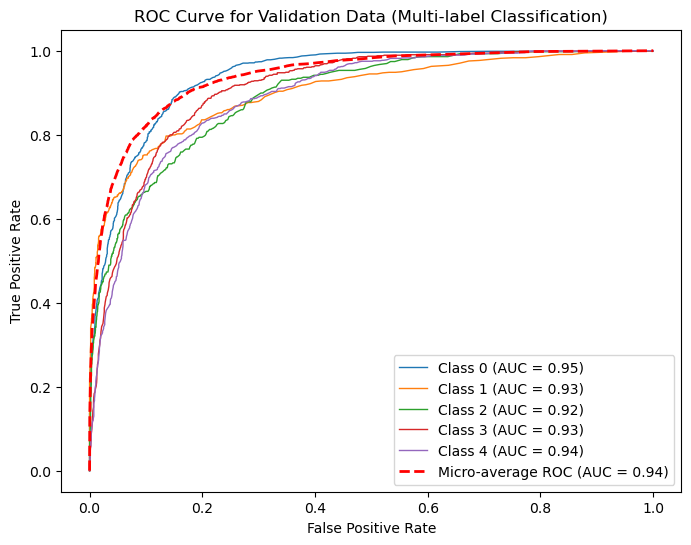

In [5]:
# 1차원 CNN Student 모델 정의
class Student_CNN1D(nn.Module):
    def __init__(self, num_classes):
        super(Student_CNN1D, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=50, kernel_size=10)
        self.conv2 = nn.Conv1d(in_channels=50, out_channels=150, kernel_size=10)
        self.conv3 = nn.Conv1d(in_channels=150, out_channels=300, kernel_size=10)
        self.relu = nn.ReLU()
        
        self.bn1 = nn.BatchNorm1d(50)
        self.bn2 = nn.BatchNorm1d(150)
        self.bn3 = nn.BatchNorm1d(300)

        self.pool = nn.MaxPool1d(kernel_size=2)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # Global Average Pooling 레이어
        self.dropout1 = nn.Dropout(0.3, inplace=False)
        self.fc = nn.Linear(300, num_classes)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, y=None):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
    
# 지식 증류 기법을 student 모델 학습
# 폴드 별 학습 및 평가
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_encoded)):
    print(f"Training Fold {fold + 1}...")
    
    # Teacher 모델 및 Student 모델 초기화
    teacher_model = CNN1D(num_classes).to(device)
    student_model = Student_CNN1D(num_classes).to(device)
    optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=learning_rate)
    optimizer_student = optim.Adam(student_model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    # 현재 폴드에 대한 데이터 로더 재정의
    train_loader = DataLoader(TensorDataset(X_train[train_idx].to(device).float(), y_train_tensor[train_idx].to(device).float()), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_train[val_idx].to(device).float(), y_train_tensor[val_idx].to(device).float()), batch_size=batch_size, shuffle=False)

    best_auc = 0.0
    no_improvement_epochs = 0
    
    # tqdm을 통해 학습 과정 표시
    for epoch in range(epochs):
        teacher_model.train()
        student_model.train()
        train_loss = 0.0
        for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer_teacher.zero_grad()
            optimizer_student.zero_grad()
            
            with torch.no_grad():
                # Teacher 모델의 출력 받기
                teacher_output = teacher_model(batch_x)
            
            # Student 모델의 출력 받기
            student_output = student_model(batch_x)
            
            loss = criterion(student_output, batch_y) + knowledge_distillation_loss(student_output, batch_y, teacher_output)
            loss.backward()
            
            optimizer_teacher.step()
            optimizer_student.step()
            
            train_loss += loss.item() * batch_x.size(0)
        average_train_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}, Average Training Loss: {average_train_loss:.4f}")

        # Validation set evaluation
        student_model.eval()
        y_scores = []
        y_true = []
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                for batch_x, batch_y in val_loader:
                    output = student_model(batch_x)
                    output = nn.functional.sigmoid(output)
                    y_scores.append(output.cpu().numpy())
                    y_true.append(batch_y.cpu().numpy())

        y_scores = np.vstack(y_scores)
        y_true = np.vstack(y_true)
        
        # 각 label 별로 ROC curve 계산
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            all_fpr.append(fpr[i])
            all_tpr.append(tpr[i])

        # validation set에 대한 AUC score 계산
        auc_score = roc_auc_score(y_true, y_scores)

        print(f"Epoch {epoch + 1}, Validation AUC: {auc_score:.4f}")

        # AUC score 확인 후 갱신
        if auc_score > best_auc:
            best_auc = auc_score
            no_improvement_epochs = 0
        else:
            # Early stopping 확인
            no_improvement_epochs += 1
            if no_improvement_epochs >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    print(f"Best AUC: {best_auc:.4f} (Epoch {epoch + 1})")

# 각 label 별로 ROC curve를 plot
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(all_fpr[i], all_tpr[i], lw=1, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Micro-average ROC curve 계산 및 plot
micro_fpr, micro_tpr, _ = roc_curve(y_true.ravel(), y_scores.ravel())
micro_auc = auc(micro_fpr, micro_tpr)
plt.plot(micro_fpr, micro_tpr, color='red', linestyle='--', lw=2, label=f'Micro-average ROC (AUC = {micro_auc:.2f})')

# Labels 과 legend 추가
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Data (Multi-label Classification)')
plt.legend(loc='lower right')
plt.show()

In [6]:
# 모델 파라미터 수 계산 함수
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 모델 인스턴스 생성
t_model = CNN1D(num_classes)
s_model = Student_CNN1D(num_classes)

# 모델의 파라미터 수 계산
t_model_total_params = count_parameters(t_model)
s_model_total_params = count_parameters(s_model)

# 모델의 파라미터 수 출력
print(f"Teacher Model(CNN1D) parameters: {t_model_total_params:,}")
print(f"Student Model(Student_CNN1D) parameters: {s_model_total_params:,}")

Teacher Model(CNN1D) parameters: 6,522,555
Student Model(Student_CNN1D) parameters: 534,005


In [7]:
from torchsummary import summary

summary(t_model.to(device), (12, 1000))
summary(s_model.to(device), (12, 1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 100, 991]          12,100
       BatchNorm1d-2             [-1, 100, 991]             200
              ReLU-3             [-1, 100, 991]               0
         MaxPool1d-4             [-1, 100, 495]               0
           Dropout-5             [-1, 100, 495]               0
            Conv1d-6             [-1, 250, 486]         250,250
       BatchNorm1d-7             [-1, 250, 486]             500
              ReLU-8             [-1, 250, 486]               0
         MaxPool1d-9             [-1, 250, 243]               0
          Dropout-10             [-1, 250, 243]               0
           Conv1d-11             [-1, 500, 234]       1,250,500
      BatchNorm1d-12             [-1, 500, 234]           1,000
             ReLU-13             [-1, 500, 234]               0
        MaxPool1d-14             [-1, 5

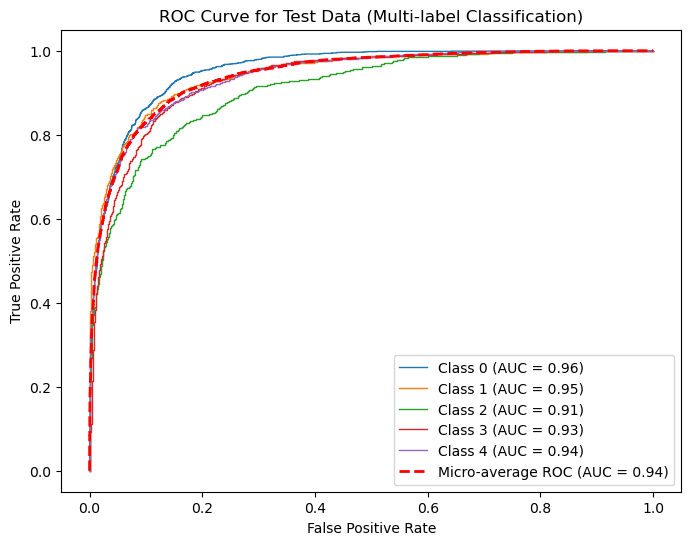

In [9]:
# 테스트 데이터 로더 정의
test_loader = DataLoader(TensorDataset(X_test.to(device).float(), y_test_tensor.to(device).float()), batch_size=batch_size, shuffle=False)

# Student 모델의 테스트
model = student_model

# 테스트 데이터에 대한 예측 확률 계산
model.eval()
y_scores_test = []
y_true_test = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        output = model(batch_x)
        y_scores_test.append(output.cpu().numpy())
        y_true_test.append(batch_y.cpu().numpy())

y_scores_test = np.vstack(y_scores_test)
y_true_test = np.vstack(y_true_test)

# 각 label 별로 ROC curve 계산
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()

for i in range(num_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_true_test[:, i], y_scores_test[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# 테스트 데이터에 대한 ROC curve를 plot
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr_test[i], tpr_test[i], lw=1, label=f'Class {i} (AUC = {roc_auc_test[i]:.2f})')

# Test 데이터 전체에 대한 Micro-average ROC curve 계산 및 plot
micro_fpr_test, micro_tpr_test, _ = roc_curve(y_true_test.ravel(), y_scores_test.ravel())
micro_auc_test = auc(micro_fpr_test, micro_tpr_test)
plt.plot(micro_fpr_test, micro_tpr_test, color='red', linestyle='--', lw=2, label=f'Micro-average ROC (AUC = {micro_auc_test:.2f})')

# Labels 과 legend 추가
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data (Multi-label Classification)')
plt.legend(loc='lower right')
plt.show()